In [1]:
import os
import graphviz
from graphviz import Digraph
import sqlite3
import pandas as pd
from typing import Optional

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
graphviz.set_jupyter_format('svg')
if 'Graphviz' not in os.environ["PATH"]:
    os.environ["PATH"] += ";C:\\Program Files\\Graphviz\\bin\\"

In [3]:
connection = sqlite3.connect(os.getenv('DB_PATH'))
cursor = connection.cursor()

In [4]:
# Get all projects
def get_all_projects(cursor: sqlite3.Cursor) -> dict:
    cursor.execute("SELECT * FROM projects")
    projects = cursor.fetchall()
    project_dict = {}
    for project in projects:
        project_id, project_name, project_description, created_at, updated_at = project
        project_dict[project_id] = {
            "name": project_name,
            "description": project_description,
            "created_at": created_at,
            "updated_at": updated_at
        }
    return project_dict


In [5]:
# Get all prompts for a project or all prompts
def get_all_prompts(cursor: sqlite3.Cursor, project_id: Optional[str] = None, output_type:str='dict') -> dict:
    
    # Prompt Table Schema
    # id TEXT PRIMARY KEY | prompt_group_id TEXT NOT NULL | project_id TEXT NOT NULL | description TEXT | parent_prompt_id TEXT | name TEXT NOT NULL | version INTEGER NOT NULL |
    # prompt_template TEXT NOT NULL | input_variables TEXT | favourite INTEGER NOT NULL | notes TEXT | created_at TEXT NOT NULL | updated_at TEXT NOT NULL |
    # FOREIGN KEY (project_id) REFERENCES projects (id) |
    
    # Execute SQL Query
    if project_id:
        cursor.execute("""
            SELECT id, prompt_group_id, project_id, parent_prompt_id, name, description, version, prompt_template, input_variables, favourite, notes, created_at, updated_at 
            FROM prompts 
            WHERE project_id = ?
            """, (project_id,))
    else:
        cursor.execute("""
            SELECT id, prompt_group_id, project_id, parent_prompt_id, name, description, version, prompt_template, input_variables, favourite, notes, created_at, updated_at 
            FROM prompts
            """)
    
    # Fetch the data
    prompts = cursor.fetchall()
    
    if output_type == 'dict':
        # Convert to dictionary
        prompt_dict = {}
        for prompt in prompts:
            id, prompt_group_id, project_id, parent_prompt_id, name, description, version, prompt_template, input_variables, favourite, notes, created_at, updated_at = prompt
            prompt_dict[id] = {
                "prompt_group_id": prompt_group_id,
                "project_id": project_id,
                "parent_prompt_id": parent_prompt_id,
                "name": name,
                "description": description,
                "version": version,
                "prompt_template": prompt_template,
                "input_variables": input_variables,
                "favourite": favourite,
                "notes": notes,
                "created_at": created_at,
                "updated_at": updated_at
        }
        
        return prompt_dict

    if output_type == 'df':
        # Convert to dataframe
        prompt_df = pd.DataFrame(prompts, columns = ['id', 'prompt_group_id', 'project_id', 'parent_prompt_id', 'name', 'description', 'version', 'prompt_template', 'input_variables', 'favourite', 'notes', 'created_at', 'updated_at'])
        return prompt_df


In [6]:
# Get all prompt groups for a project or all prompt groups
def get_all_prompt_groups(cursor: sqlite3.Cursor, project_id: Optional[str] = None) -> dict:

        # Execute SQL Query
        if project_id:
            cursor.execute("""
                SELECT id, prompt_group_id, project_id, parent_prompt_id, name, description, version, prompt_template, input_variables, favourite, notes, created_at, updated_at 
                FROM prompts 
                WHERE project_id = ?
                """, (project_id,))
        else:
            cursor.execute("""
                SELECT id, prompt_group_id, project_id, parent_prompt_id, name, description, version, prompt_template, input_variables, favourite, notes, created_at, updated_at 
                FROM prompts
                """)
        
        # Fetch the data
        prompts = cursor.fetchall()
        
        # Convert to dictionary
        prompt_dict = {}
        for prompt in prompts:
            id, prompt_group_id, project_id, parent_prompt_id, name, description, version, prompt_template, input_variables, favourite, notes, created_at, updated_at = prompt
            prompt_dict[prompt_group_id] = {
                "project_id": project_id,
                "parent_prompt_id": parent_prompt_id,
                "name": name,
                "description": description,
                "version": version,
                "prompt_template": prompt_template,
                "input_variables": input_variables,
                "favourite": favourite,
                "notes": notes,
                "created_at": created_at,
                "updated_at": updated_at
            }
            
        return prompt_dict


In [7]:
# Get all prompt versions
def get_all_prompt_versions(cursor: sqlite3.Cursor, prompt_group_id: str) -> pd.DataFrame:
    cursor.execute("SELECT id, version, input_variables, notes, favourite FROM prompts WHERE prompt_group_id = ?", (prompt_group_id,))
    versions = cursor.fetchall()
    
    data = {
        "id": [],
        "version": [],
        "input_variables": [],
        "notes": [],
        "favourite": []
    }
    
    for version in versions:
        id, version, input_variables, notes, favourite = version
        data["id"].append(id)
        data["version"].append(version)
        data["input_variables"].append(input_variables)
        data["notes"].append(notes)
        data["favourite"].append(bool(favourite))
    
    # Create a DataFrame
    prompt_version_df = pd.DataFrame(data)
    
    # Sort the DataFrame by version in descending order
    prompt_version_df = prompt_version_df.sort_values(by="version", ascending=False)
    
    return prompt_version_df


In [13]:
projects = get_all_projects(cursor)

In [14]:
idx = 1
list(projects.keys())[idx], projects[list(projects.keys())[idx]]

('25f4dfed2ea7162a8152914b539aefd5bf0adcf68d5417ad7624cc160be48161',
 {'name': 'TMHCC - News Analysis',
  'description': 'Analysing the daily news articles by:\n1. Checking if News Articles is about any of the given public entity\n2. Assign all the relevant LOB tags\n3. Determine a risk score for each LOB tag\n4. Give an overall Risk score',
  'created_at': '2024-03-05 00:17:06',
  'updated_at': '2024-03-05 00:17:06'})

In [10]:
prompt_groups = get_all_prompt_groups(cursor, list(projects.keys())[idx])

In [11]:
prompt_groups.keys()

dict_keys(['1600f0ea164d9fd8e967ca9a164e709adb141543bbe9089f30be4adb65e06023', '1f075a3c12a721c07a30e172c09cfb45468acce7058b654db9fdd662584612f4', '010ee22c0f1752a54aef286814359e16b6e04e586143591463d1680ff81a8403'])

In [15]:
prompts = get_all_prompts(cursor, list(projects.keys())[idx], output_type='df')

In [9]:
import re

def replace_space_with_newline(text):
    return re.sub(r'(\w+\s+\w+)\s+', r'\1\n', text)


In [10]:
print(replace_space_with_newline("This is a test of the emergency broadcast system. This is only a test."))

This is
a test
of the
emergency broadcast
system. This is
only a
test.


In [18]:
g = Digraph('G', engine='dot') #['circo', 'dot', 'fdp', 'neato', 'osage', 'patchwork', 'sfdp', 'twopi']

with g.subgraph(name='project') as parent:
    # parent.attr(label=projects[list(projects.keys())[idx]]['name'])
    # parent.node('A', 'Project')
    
    for cluster_idx, prompt_group_id in enumerate(prompts.prompt_group_id.unique()):
        subprompts:pd.DataFrame = prompts[prompts.prompt_group_id == prompt_group_id].copy(deep=True)
        subgraph_name:str = subprompts.name.values[0]
        with g.subgraph(name=f'cluster_{cluster_idx} - {subgraph_name}') as c:
            if len(subgraph_name.split()) > 2:
                subgraph_name = replace_space_with_newline(subgraph_name)
            
            c.attr(label=subgraph_name, rank='same')
            
            for prompt_idx, prompt in subprompts.iterrows():
                c.node(name=prompt.id, label=f'v{str(prompt.version)}')

for prompt_idx, prompt in prompts.iterrows():
    if prompt.parent_prompt_id:
        for parent_idx in prompt.parent_prompt_id.split(','):
            g.edge(parent_idx, prompt.id)
    # else:
    #     g.edge('A', prompt.id)

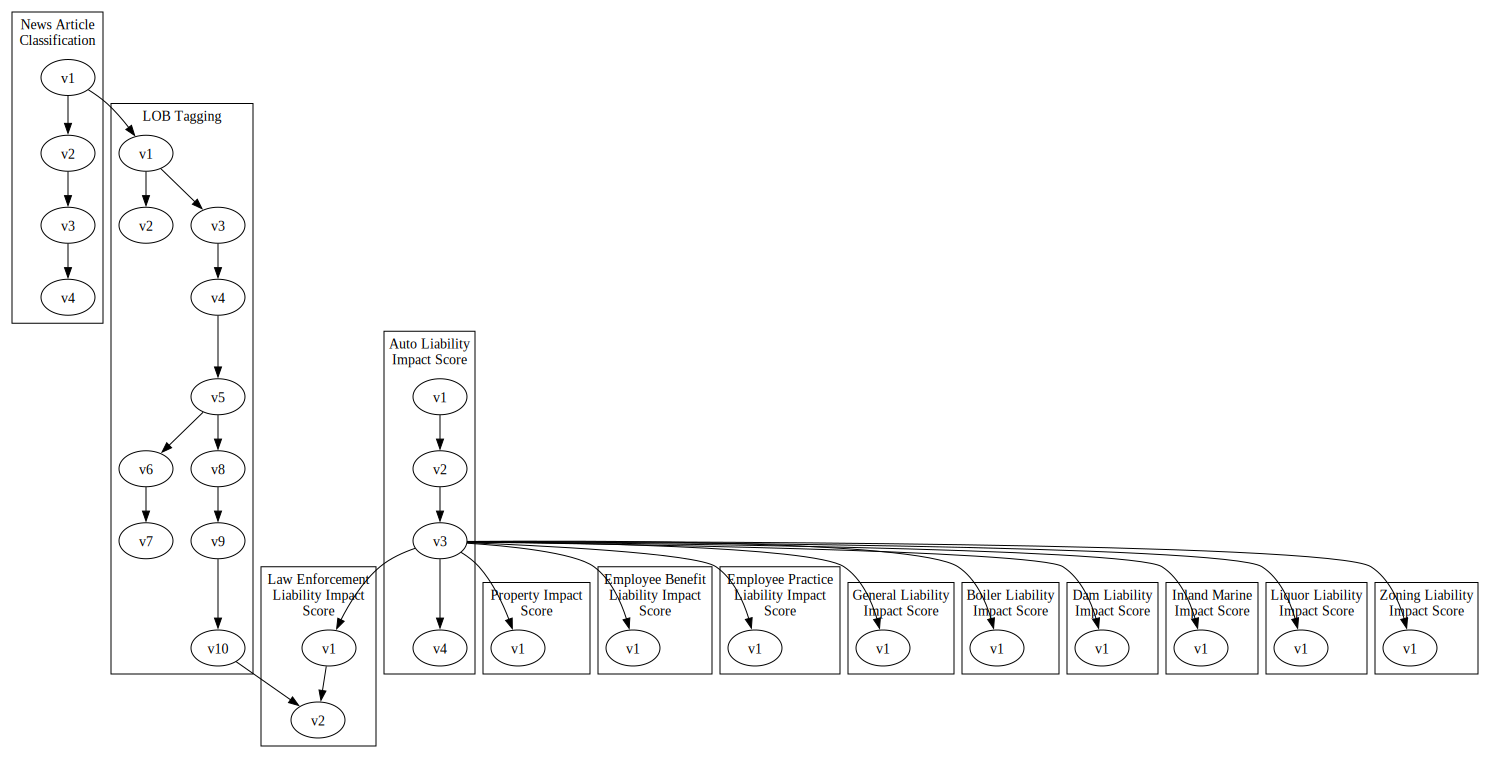

In [19]:
g